In [1]:
from google.colab import files
uploaded = files.upload()

Saving Ceramic-Concrete-Dataset.csv to Ceramic-Concrete-Dataset.csv


In [10]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import joblib

# Plotting style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)


In [11]:
# 2. Load Data
df = pd.read_csv('Ceramic-Concrete-Dataset.csv')

# Feature Engineering
df['WaterCementRatio'] = df['Water'] / (df['Cement'] + 1e-6)
df['TotalAggregate'] = df['FineAggregate'] + df['CoarseAggregate']
df['CementContent'] = df['Cement'] / (df['Cement'] + df['CeramicWastePowder'] + 1e-6)

# Define features and target
features = [
    'Cement', 'CeramicWastePowder', 'FineAggregate',
    'CoarseAggregate', 'Water', 'WaterCementRatio',
    'TotalAggregate', 'CementContent'
]
target = 'CompressiveStrength'

# Check for missing values
print(df.isnull().sum())


Cement                 0
CeramicWastePowder     0
FineAggregate          0
CoarseAggregate        0
Water                  0
CompressiveStrength    0
WaterCementRatio       0
TotalAggregate         0
CementContent          0
dtype: int64


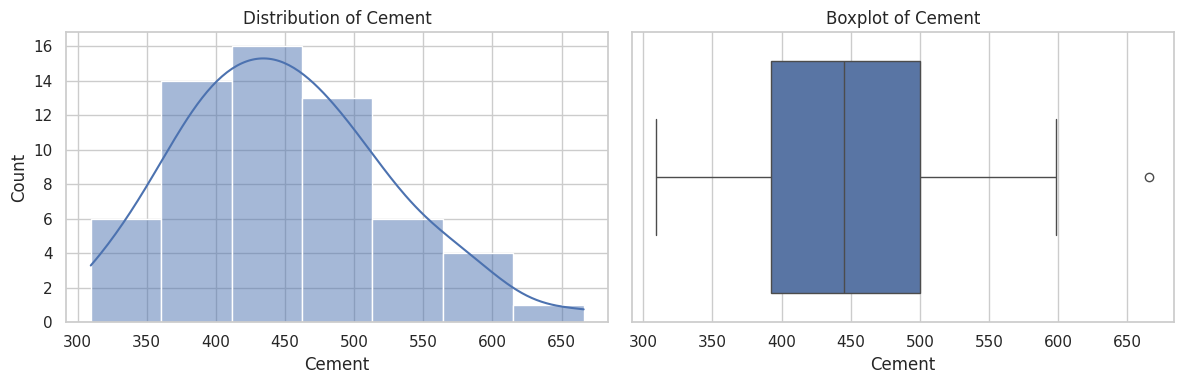

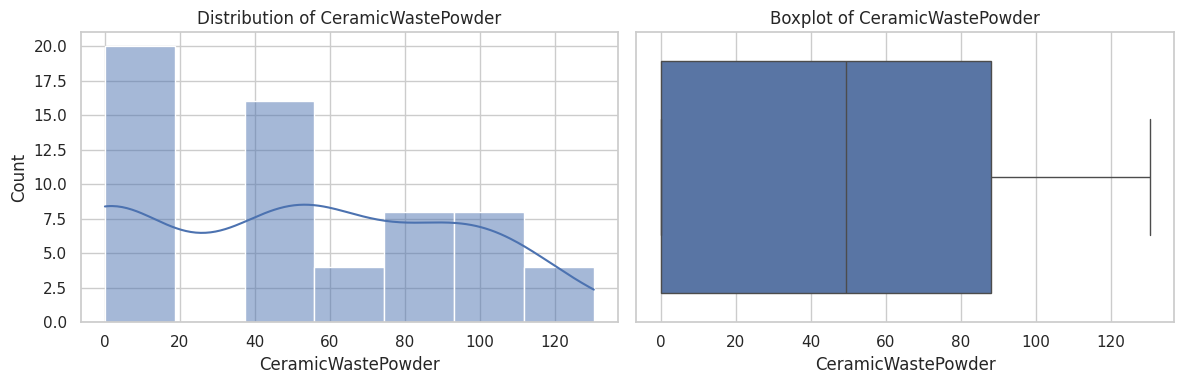

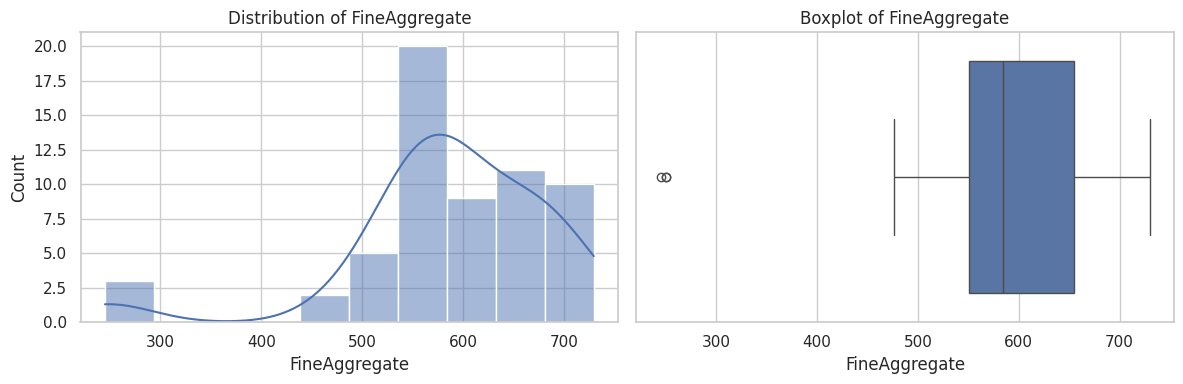

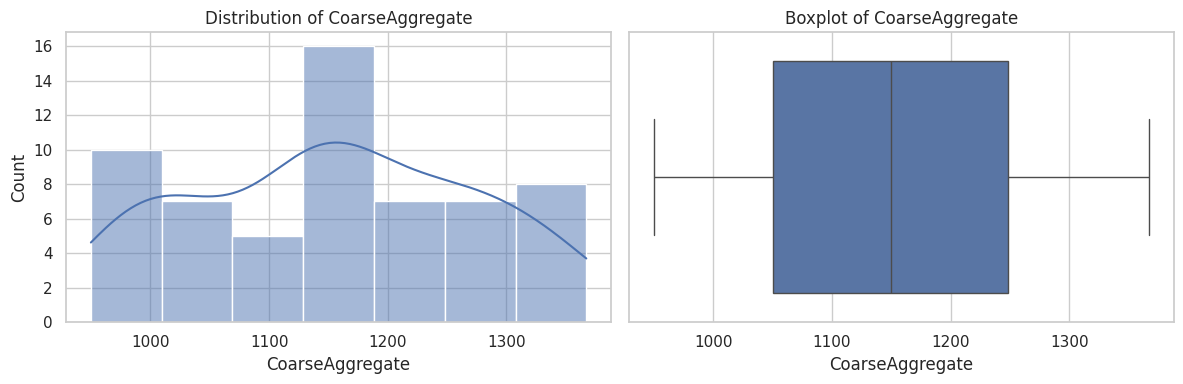

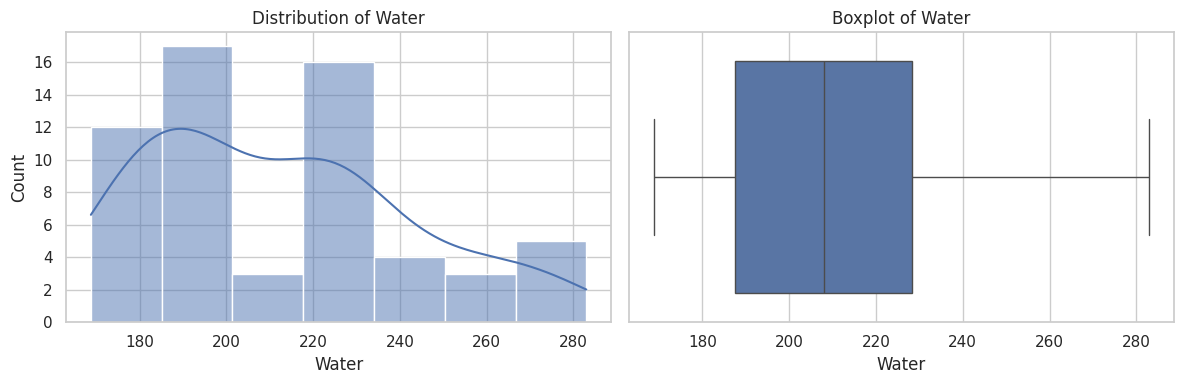

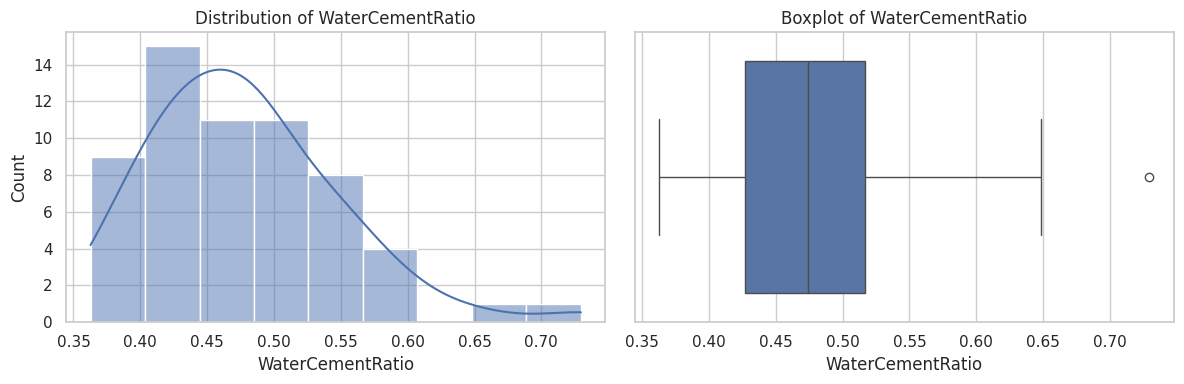

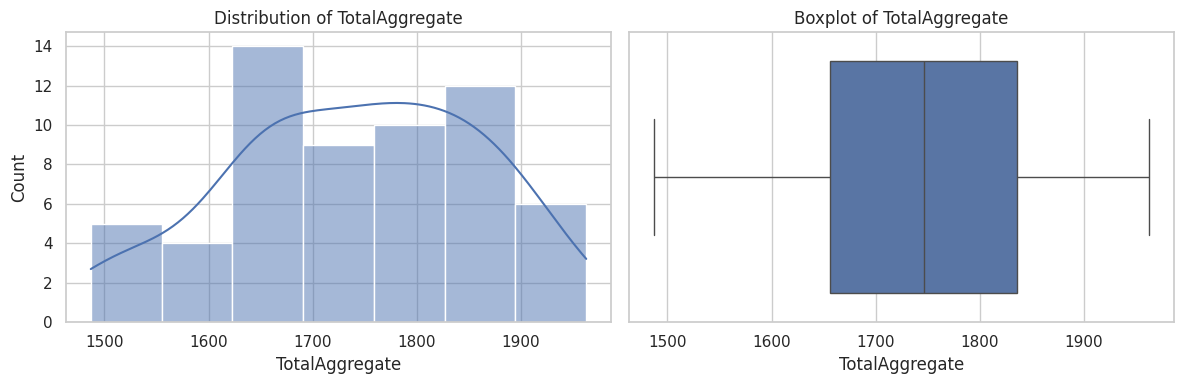

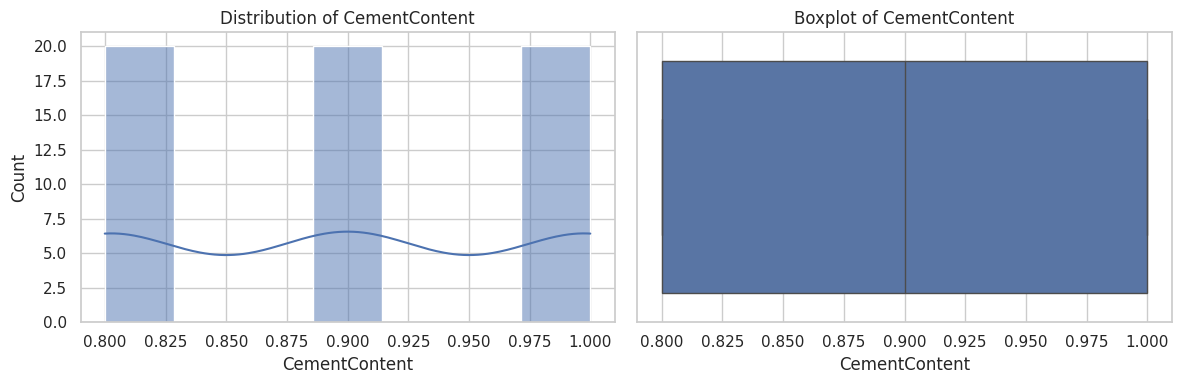

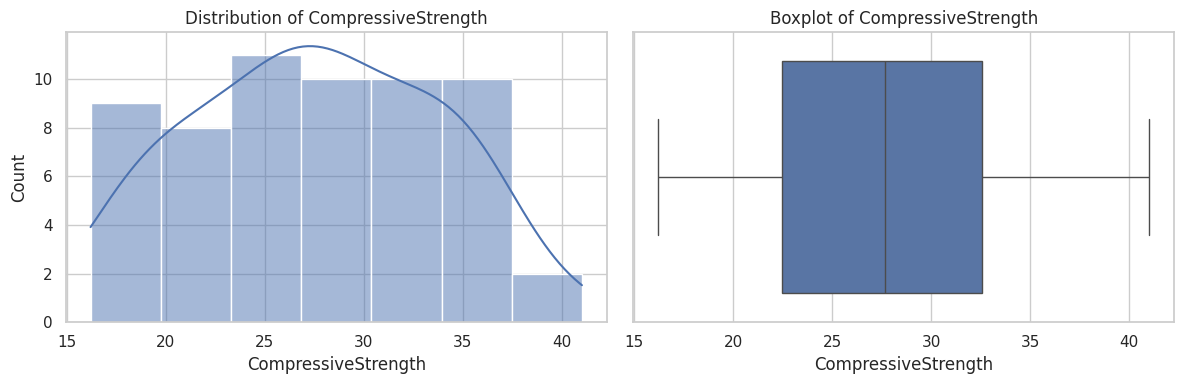

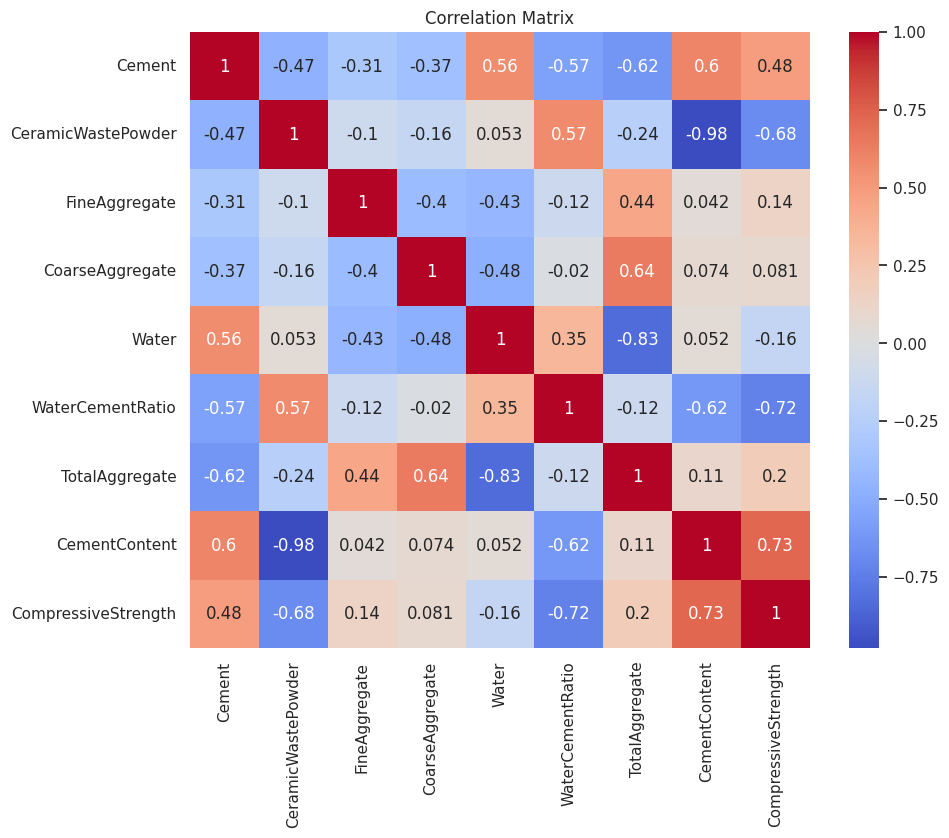

In [12]:
# 3. EDA
# Distributions
for col in features + [target]:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[col], kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution of {col}')
    sns.boxplot(x=df[col], ax=ax[1])
    ax[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

# Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(df[features + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [13]:
# 4. Train-Test Split
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [14]:
# 5. Preprocessing: Scale features (not target)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [16]:
# 6. Model Training & Hyperparameter Tuning
models = {
    'Ridge': {
        'model': Ridge(),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'Lasso': {
        'model': Lasso(max_iter=10000),
        'params': {'alpha': [0.01, 0.1, 1, 10, 100]}
    },
    'ElasticNet': {
        'model': ElasticNet(max_iter=10000),
        'params': {'alpha': [0.01, 0.1, 1], 'l1_ratio': [0.2, 0.5, 0.8]}
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': [100, 200], 'max_depth': [3, 5], 'learning_rate': [0.01, 0.1]}
    }
}

results = []
best_models = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)
    best_models[name] = grid.best_estimator_
    y_pred = grid.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({'Model': name, 'Best Params': grid.best_params_, 'Test RMSE': rmse, 'Test MAE': mae, 'Test R2': r2})

results_df = pd.DataFrame(results)
print(results_df.sort_values('Test R2', ascending=False))



Training Ridge...

Training Lasso...

Training ElasticNet...

Training GradientBoosting...
              Model                                        Best Params  \
2        ElasticNet                   {'alpha': 0.01, 'l1_ratio': 0.2}   
0             Ridge                                       {'alpha': 1}   
1             Lasso                                    {'alpha': 0.01}   
3  GradientBoosting  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...   

   Test RMSE  Test MAE   Test R2  
2   2.638664  2.029821  0.786598  
0   2.654021  2.117890  0.784107  
1   2.697974  1.965658  0.776897  
3   3.285405  2.415371  0.669168  


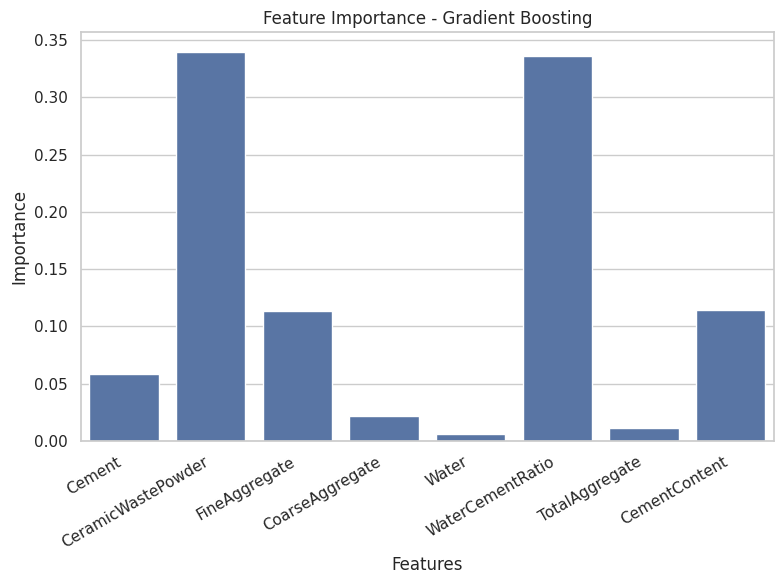

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(x=features, y=importances)
plt.title('Feature Importance - Gradient Boosting')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=30, ha='right')  # Rotate x labels for readability
plt.tight_layout()
plt.show()


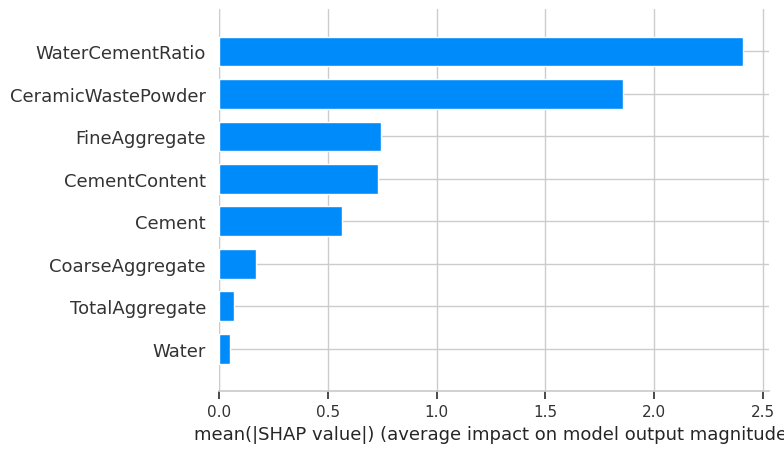

In [18]:
# 8. SHAP Interpretation (for Best Model)
explainer = shap.Explainer(best_gb, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type='bar')


In [19]:
# 9. Save the Best Model and Scaler
joblib.dump({'model': best_gb, 'scaler': scaler, 'features': features}, 'best_concrete_model.pkl')
print("Best model and scaler saved.")

Best model and scaler saved.
